In [1]:

import torch
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, MetricTracker
torch.set_default_dtype(torch.float32)

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
from fiora.GNN.MLP import MLP
from fiora.GNN.MLPEdgeClassifier import MLPEdgeClassifier
from fiora.GNN.GNNModels import GCNNodeClassifier
from fiora.GNN.Datasets import  SimpleNodeData, NodeSingleLabelData
from fiora.GNN.Trainer import Trainer
from fiora.MOL.constants import DEFAULT_PPM, PPM



from fiora.IO.LibraryLoader import LibraryLoader

##### Aromaticity Test Prediction

In [2]:
#library_name = "nist_msms_filtered"
library_name = "nist_msms_filteredall_07_2023"

library_directory = f"{home}/data/metabolites/NIST17/msp/nist_msms/"


L = LibraryLoader()
df = L.load_from_csv(library_directory + library_name + ".csv")


In [3]:
import ast

test_run = False

if test_run:
    df = df.iloc[:10000,:]


# Restore dictionary values
dict_columns = ["peaks"]
for col in dict_columns:
    df[col] = df[col].apply(ast.literal_eval)
print("Loaded DataFrame of shape: ", df.shape)

Loaded DataFrame of shape:  (118888, 45)


Compute graph features

In [4]:
%%capture
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder

df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight"])
df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))


metadata_key_map = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "ionization": "Ionization",
                 "precursor_mz": "PrecursorMZ"
                 }

df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder=None), axis=1)

In [5]:
print("Assigning unique metabolite identifiers.")

metabolite_id_map = {}

for metabolite in df["Metabolite"]:
    is_new = True
    for id, other in metabolite_id_map.items():
        if metabolite == other:
            metabolite.id = id
            is_new = False
            break
    if is_new:
        new_id = len(metabolite_id_map)
        metabolite.id = new_id
        metabolite_id_map[new_id] = metabolite
        
print(f"Found {len(metabolite_id_map)} unique molecular structures.")

Assigning unique metabolite identifiers.
Found 9646 unique molecular structures.


In [ ]:
from fiora.MOL.mol_graph import draw_graph
from fiora.visualization.define_colors import *
import matplotlib.pyplot as plt

EXAMPLE_ID = 32271
example = df.loc[EXAMPLE_ID]
m = example["Metabolite"]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1]}, sharey=False)
set_light_theme()

img = m.draw(ax=axs[0])
draw_graph(m.Graph, ax=axs[1])

#### Bond Features

Plotting the occurance of bond types shows how unbalanced the data set is. Regardless, we wish to classify bonds (and atoms) by their type. For simplicity we only consider the two classes *aromatic* and *non-aromatic*, which include all other bond types. By classifying all bonds as non-aromatic any algorithm will already achieve 65% accuaracy. For completion, see below all elements detected in the dataset.

#### Atom Features

In [ ]:
# elems = [e for mol in list(df["Metabolite"].apply(lambda x: getattr(x, "node_elements")).values) for e in mol]
# elem_types = {e: elems.count(e) for e in np.unique(elems)}

# fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), sharey=False)
# sns.barplot(ax=axs[0], x=list(elem_types.keys()), y=list(elem_types.values()), palette=color_palette, edgecolor="black", linewidth=1.5)
# _,labels,autotexts = axs[1].pie(list(elem_types.values()), colors=color_palette, wedgeprops={"edgecolor": "black", "linewidth": 1.5}, autopct='%1.0f%%')

# axs[1].legend(list(elem_types.keys()))
# plt.show()
# print(elem_types)
# cno = (elem_types["C"]+elem_types["O"]+elem_types["N"])*100 / sum(elem_types.values())
# print(f"With {cno:.01f}% CNO")

#### Metadata

In [12]:
np.min(df["Metabolite"].apply(lambda x: x.metadata["collision_energy"]))

0.0

#### Peak annotations


In [16]:
print("Testing matching accuracies")
print("100 *PPM: " ,100 *PPM)

Testing matching accuracies
100 *PPM:  9.999999999999999e-05


In [17]:
%%capture
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 *PPM), axis=1)

In [18]:
d100 = pd.DataFrame({"num_peak_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"]),
     "num_non_precursor_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_non_precursor_matches"]),
     "num_peak_match_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_match_conflicts"]),
     "num_fragment_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_fragment_conflicts"]),
     "group": "100 PPM"})
#raise KeyboardInterrupt

In [20]:
# # TODO DO NICEEEEEEEEE

# coverage_tracker = {"counts": [], "all": [], "coverage": [], "fragment_only_coverage": [], "Precursor_type": []}

# drop_index = []
# for i,d in df.iterrows():
#     M = d["Metabolite"]
    
    
#     coverage_tracker["counts"] += [M.match_stats["counts"]]
#     coverage_tracker["all"] += [M.match_stats["ms_all_counts"]]
#     coverage_tracker["fragment_only_coverage"] += [M.match_stats["coverage_wo_prec"]]
#     coverage_tracker["coverage"] += [M.match_stats["coverage"]]
#     #coverage_tracker["Precursor_type"] += [M.metadata["precursor_mode"]]
    
#     #if M.edge_break_prob_wo_precursor.sum() <= 0.01:
#     #    drop_index.append(i)
#     #if M.edge_break_prob.sum() < 0.05: # TODO
#     #    drop_index.append(i)
    
#     if M.match_stats["coverage"] < 0.5: # Filter if total coverage is too low
#         drop_index.append(i)
#     #if M.match_stats["coverage_wo_prec"] < 0.1: # Filter if fragment coverage is too low (intensity wise)
#     #    drop_index.append(i)
    
# # filter low res instruments TODO update to low quality spectra
# is_iontrap = df["Metabolite"].apply(lambda x: x.metadata["instrument"] == "IT/ion trap")
# drop_index += list(df[is_iontrap].index)

# fig, axs = plt.subplots(1, 3, figsize=(12.8, 4.2), sharey=True)

# plt.ylim([-.02,1.02])
# sns.boxplot(ax=axs[0], data=coverage_tracker, y="fragment_only_coverage", color=magma_palette[1])
# sns.boxplot(ax=axs[1], data=coverage_tracker, y="coverage", color=magma_palette[2])
# sns.violinplot(ax=axs[2], data=coverage_tracker, y="coverage", color=magma_palette[2])
# axs[0].set_title("Coverage of peak intensity (fragments only)")
# axs[1].set_title("Coverage of peak intensity")
# axs[2].set_title("Coverage of peak intensity")
# plt.show()

# print(f"Found {len(drop_index)} that have only precursor matches || or || too little (intensity) coverage to make edge prediction possible")


In [21]:
%%capture
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=200 *PPM), axis=1)


d200 = pd.DataFrame({"num_peak_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"]),
     "num_non_precursor_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_non_precursor_matches"]),
     "num_peak_match_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_match_conflicts"]),
     "num_fragment_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_fragment_conflicts"]),
     "group": "200 PPM"})


In [22]:
%%capture
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=500 *PPM), axis=1)

d500 = pd.DataFrame({"num_peak_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"]),
     "num_non_precursor_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_non_precursor_matches"]),
     "num_peak_match_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_match_conflicts"]),
     "num_fragment_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_fragment_conflicts"]),
     "group": "500 PPM"})


In [23]:
%%capture
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=1000 *PPM), axis=1)
d1000 = pd.DataFrame({"num_peak_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"]),
     "num_non_precursor_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_non_precursor_matches"]),
     "num_peak_match_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_match_conflicts"]),
     "num_fragment_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_fragment_conflicts"]),
     "group": "1000 PPM"})

df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=10 *PPM), axis=1)
d10 = pd.DataFrame({"num_peak_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"]),
     "num_non_precursor_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_non_precursor_matches"]),
     "num_peak_match_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_match_conflicts"]),
     "num_fragment_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_fragment_conflicts"]),
     "group": "10 PPM"})

We see a significant bump up at 200 PPM.

#### Double down on peak matches

In [26]:
# %%capture
# df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
# df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 *PPM), axis=1)

In [27]:

# df["peak_matches"] = df["Metabolite"].apply(lambda x: getattr(x, "peak_matches"))
# df["num_peaks_matched"] = df["peak_matches"].apply(len)


# def get_match_stats(matches, mode_count={"[M+H]+": 0, "[M-H]+": 0, "[M-3H]+": 0}):
#     num_unique, num_conflicts = 0, 0
#     for mz, match_data in matches.items():
#         #candidates = match_data["fragments"]
#         ion_modes = match_data["ion_modes"]
#         if len(ion_modes) == 1:
#             num_unique += 1
#         elif len(ion_modes) > 1:
#             num_conflicts += 1
#         for c in ion_modes:
#             mode_count[c[0]] += 1
#     return num_unique, num_conflicts, mode_count
# d = df.loc[EXAMPLE_ID]



# df["match_stats"] = df["peak_matches"].apply(lambda x: get_match_stats(x))
# df["num_unique_peaks_matched"] = df.apply(lambda x: x["match_stats"][0], axis=1)
# df["num_conflicts_in_peak_matching"] = df.apply(lambda x: x["match_stats"][1], axis=1)
# df["match_mode_counts"] = df.apply(lambda x: x["match_stats"][2], axis=1)
# u= df["num_unique_peaks_matched"].sum() 
# s= df["num_conflicts_in_peak_matching"].sum() 
# print(f"Total number of uniquely matched peaks: {u} , conflicts found within {s} matches ({100 * s / (u+s):.02f} %))")
# print(f"Total number of conflicting peak to fragment matches: {s}")

# df.shape
 

In [29]:
# fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), sharey=False)

# mode_counts = {"[M+H]+": 0, "[M-H]+": 0, "[M-3H]+": 0}

# def update_mode_counts(m):
#     for mode in m.keys():
#         mode_counts[mode] += m[mode]

# df["match_mode_counts"].apply(update_mode_counts)

# sns.barplot(ax=axs[0], x=list(mode_counts.keys()), y=[mode_counts[k] for k in mode_counts.keys()], palette=color_palette, edgecolor="black", linewidth=1.5)
# axs[1].pie([mode_counts[k] for k in mode_counts.keys()], labels=list(mode_counts.keys()), colors=color_palette, wedgeprops={"edgecolor": "black", "linewidth": 1.5})

# plt.show()

In [30]:

for i in range(0,6):
    print(f"Minimum {i} unique peaks identified (including precursors): ", (df["num_unique_peaks_matched"] >= i).sum())


Minimum 0 unique peaks identified (including precursors):  118888
Minimum 1 unique peaks identified (including precursors):  108912
Minimum 2 unique peaks identified (including precursors):  93311
Minimum 3 unique peaks identified (including precursors):  74336
Minimum 4 unique peaks identified (including precursors):  54895
Minimum 5 unique peaks identified (including precursors):  39429


In [31]:
# modes = ["[M+H]+", "[M-H]+", "[M-3H]+", "[M]+", "[M-2H]+"]
# df["Metabolite"].apply(lambda x: x.fragmentation_tree.set_fragment_modes(modes)) 
# df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 *PPM, mode_mapper={"[M+H]+": 0, "[M-H]+": 1, "[M-3H]+": 2, "[M]+": 3, "[M-2H]+": 4}), axis=1)

In [32]:

# df["peak_matches"] = df["Metabolite"].apply(lambda x: getattr(x, "peak_matches"))
# df["num_peaks_matched"] = df["peak_matches"].apply(len)
# df["match_stats"] = df["peak_matches"].apply(lambda x: get_match_stats(x,mode_count={"[M+H]+": 0, "[M-H]+": 0, "[M-3H]+": 0, "[M]+": 0, "[M-2H]+": 0}))
# df["num_unique_peaks_matched"] = df.apply(lambda x: x["match_stats"][0], axis=1)
# df["num_conflicts_in_peak_matching"] = df.apply(lambda x: x["match_stats"][1], axis=1)
# df["match_mode_counts"] = df.apply(lambda x: x["match_stats"][2], axis=1)
# u= df["num_unique_peaks_matched"].sum() 
# s= df["num_conflicts_in_peak_matching"].sum() 
# print(f"Total number of uniquely matched peaks: {u} , conflicts found within {s} matches ({100 * s / (u+s):.02f} %))")
# print(f"Total number of conflicting peak to fragment matches: {s}")

# df.shape
 

In [34]:
# fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), sharey=False)

# mode_counts = {"[M+H]+": 0, "[M-H]+": 0, "[M-3H]+": 0, "[M]+": 0, "[M-2H]+": 0}

# def update_mode_counts(m):
#     for mode in m.keys():
#         mode_counts[mode] += m[mode]

# df["match_mode_counts"].apply(update_mode_counts)

# sns.barplot(ax=axs[0], x=list(mode_counts.keys()), y=[mode_counts[k] for k in mode_counts.keys()], palette=color_palette, edgecolor="black", linewidth=1.5)
# axs[1].pie([mode_counts[k] for k in mode_counts.keys()], labels=list(mode_counts.keys()), colors=color_palette, wedgeprops={"edgecolor": "black", "linewidth": 1.5})

# plt.show()

### MS DIAL library


In [35]:
library_name = "ms_dial_filteredall_08_2023"
library_directory = f"{home}/data/metabolites/MS_DIAL/"


L = LibraryLoader()
df = L.load_from_csv(library_directory + library_name + ".csv")

import ast
# Restore dictionary values
dict_columns = ["peaks"]
for col in dict_columns:
    df[col] = df[col].apply(ast.literal_eval)


In [36]:
if library_name.startswith("ms_dial"):
    qtof_nametags = ["QTOF", "LC-ESI-QTOF", "ESI-QTOF"]
    df["Instrument_type"] = df["INSTRUMENTTYPE"].apply(lambda x: "HCD" if x == "Orbitrap" else "Q-TOF" if x in qtof_nametags else x)
    df["Ionization"] = "ESI"
    df["RETENTIONTIME"] = df["RETENTIONTIME"].astype(float)
    df["PRECURSORMZ"] = df["PRECURSORMZ"].astype(float)
    df["Precursor_type"] = "PRECURSORTYPE"
    
    metadata_key_map = {
                 "collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "ionization": "Ionization",
                 "precursor_mz": "PRECURSORMZ",
                 "precursor_mode": "PRECURSORTYPE",
                 "retention_time": "RETENTIONTIME"
                 }
    
else:
    metadata_key_map = {
                 "collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "ionization": "Ionization",
                 "precursor_mz": "PrecursorMZ",
                 "precursor_mode": "Precursor_type"
                 }

In [37]:
#%%capture
from fiora.MOL.Metabolite import Metabolite
from fiora.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from fiora.GNN.BondFeatureEncoder import BondFeatureEncoder
from fiora.GNN.SetupFeatureEncoder import SetupFeatureEncoder
#
test_run = False
filter_spectra = True
CE_upper_limit = 100.0
weight_upper_limit = 800.0


if test_run:
    df = df.iloc[5000:6000,:]



df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight", "precursor_mode", "instrument"])
rt_encoder = SetupFeatureEncoder(feature_list=["molecular_weight", "precursor_mode", "instrument"])

if filter_spectra:
    setup_encoder.normalize_features["collision_energy"]["max"] = CE_upper_limit 
    setup_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
    rt_encoder.normalize_features["molecular_weight"]["max"] = weight_upper_limit 
df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))

df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder, rt_encoder), axis=1)

if filter_spectra:
    num_ori = df.shape[0]
    correct_energy = df["Metabolite"].apply(lambda x: x.metadata["collision_energy"] < CE_upper_limit) 
    df = df[correct_energy]
    correct_weight = df["Metabolite"].apply(lambda x: x.metadata["molecular_weight"] < weight_upper_limit)
    df = df[correct_weight]    
    print(f"Filtering spectra ({num_ori}) down to {df.shape[0]}")
    #print(df["Precursor_type"].value_counts())


Filtering spectra (193579) down to 175802


In [38]:
print("Assigning unique metabolite identifiers.")

metabolite_id_map = {}

for metabolite in df["Metabolite"]:
    is_new = True
    for id, other in metabolite_id_map.items():
        if metabolite == other:
            metabolite.id = id
            is_new = False
            break
    if is_new:
        new_id = len(metabolite_id_map)
        metabolite.id = new_id
        metabolite_id_map[new_id] = metabolite
        
print(f"Found {len(metabolite_id_map)} unique molecular structures.")

Assigning unique metabolite identifiers.
Found 9659 unique molecular structures.


In [39]:
%%capture
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 *PPM), axis=1)

In [40]:
d100m = pd.DataFrame({"num_peak_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"]),
     "num_non_precursor_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_non_precursor_matches"]),
     "num_peak_match_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_match_conflicts"]),
     "num_fragment_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_fragment_conflicts"]),
     "group": "100 PPM"})


In [41]:
%%capture
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=200 *PPM), axis=1)


d200m = pd.DataFrame({"num_peak_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"]),
     "num_non_precursor_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_non_precursor_matches"]),
     "num_peak_match_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_match_conflicts"]),
     "num_fragment_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_fragment_conflicts"]),
     "group": "200 PPM"})


In [42]:
%%capture
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=500 *PPM), axis=1)

d500m = pd.DataFrame({"num_peak_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"]),
     "num_non_precursor_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_non_precursor_matches"]),
     "num_peak_match_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_match_conflicts"]),
     "num_fragment_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_fragment_conflicts"]),
     "group": "500 PPM"})
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=1000 *PPM), axis=1)
d1000m = pd.DataFrame({"num_peak_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"]),
     "num_non_precursor_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_non_precursor_matches"]),
     "num_peak_match_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_match_conflicts"]),
     "num_fragment_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_fragment_conflicts"]),
     "group": "1000 PPM"})

df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=10 *PPM), axis=1)
d10m = pd.DataFrame({"num_peak_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"]),
     "num_non_precursor_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_non_precursor_matches"]),
     "num_peak_match_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_match_conflicts"]),
     "num_fragment_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_fragment_conflicts"]),
     "group": "10 PPM"})

(-0.5, 15.0)

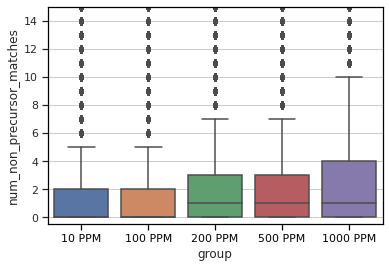

In [43]:
from fiora.visualization.define_colors import set_light_theme
mcat = pd.concat([d10m, d100m, d200m, d500m, d1000m])
set_light_theme()
sns.boxplot(data=mcat, y="num_non_precursor_matches", x="group")
plt.ylim([-0.5, 15])


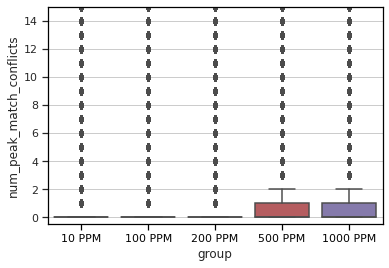

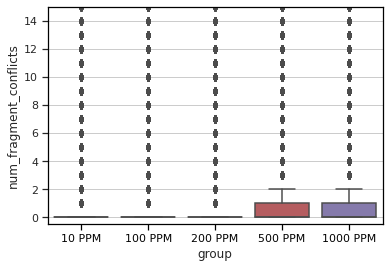

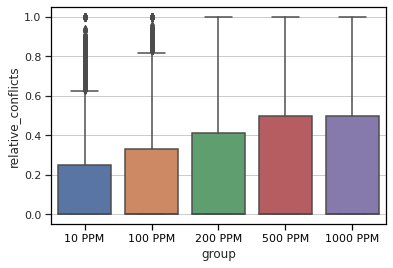

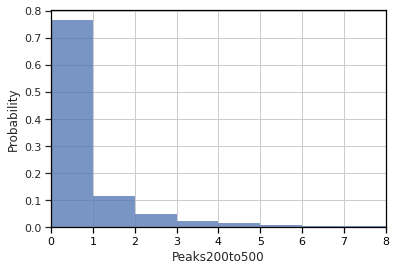

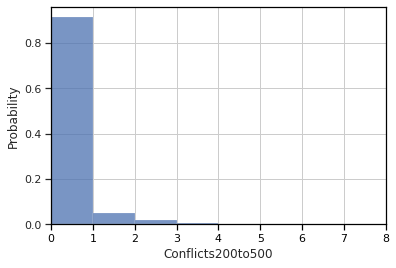

In [44]:
mcat["relative_conflicts"] = mcat["num_fragment_conflicts"] / mcat["num_non_precursor_matches"]

sns.boxplot(data=mcat, y="num_peak_match_conflicts", x="group")
plt.ylim([-0.5, 15])
plt.show()
sns.boxplot(data=mcat, y="num_fragment_conflicts", x="group")
plt.ylim([-0.5, 15])
plt.show()

sns.boxplot(data=mcat, y="relative_conflicts", x="group")
#plt.ylim([-0.5, 15])
plt.show()


dm = pd.DataFrame()
dm["Peaks200to500"] = d500m["num_non_precursor_matches"] - d200m["num_non_precursor_matches"]
dm["Conflicts200to500"] = d500m["num_fragment_conflicts"] - d200m["num_fragment_conflicts"]
sns.histplot(dm, x="Peaks200to500", binwidth=1, stat="probability")
plt.xlim([0, 8])
plt.show()
sns.histplot(dm, x="Conflicts200to500", binwidth=1, stat="probability")
plt.xlim([0, 8])
plt.show()